In [1]:
import pandas as pd 
import numpy as np

import pysam

import matplotlib.pyplot as plt
from upsetplot import UpSet


### Transform TRGT format of input regions to tandemTwister/vamos format 

In [2]:
df_TRGT_pathogenic = pd.read_csv("/confidential/tGenVar/Lion/TandemTwist/pathogenic_TR_TRGT.tsv", sep="\t")

df_TRGT_pathogenic.columns = ['chrom', 'start', 'end', 'ID']

#chr16   66490398        66490467        ID=BEAN1;MOTIFS=TGGAA,TAAAA;STRUC=<BEAN1>
# parse the ID field and split it into ID, MOTIFS
df_TRGT_pathogenic['name'] = df_TRGT_pathogenic['ID'].str.split(';').str[0].str.split('=').str[1]
# get the motifs from MOTIFS field
df_TRGT_pathogenic['MOTIFS'] = df_TRGT_pathogenic['ID'].str.split(';').str[1].str.split('=').str[1]
df_TRGT_pathogenic.drop('ID', axis=1, inplace=True)
# order the columns, chrom, start, end, MOTIFS, name
df_TRGT_pathogenic.to_csv("/confidential/tGenVar/Lion/TandemTwist/pathogenic_TRs.bed", sep="\t", index=False, header=False)

### Transform tandemTwister/vamos  format of input regions to TRGT format 

In [ ]:

# read the bed file
df = pd.read_csv('/confidential/tGenVar/Lion/TandemTwist/vamos.motif.hg38.v2.1.e0.1.tsv', sep='\t', header=None)
df = df.iloc[:,0:4]
df.columns = ['chrom', 'start', 'end', 'motifs']

def process_row(row):
    chrom = row[0]
    start = row[1]
    end = row[2]
    motifs = row[3].split(',')
    # schuffle the motif list 
    motifs= np.random.permutation(motifs)
    struc = '(' + ')n('.join(motifs) + ')n'
    return f'ID={chrom}_{start}_{end};MOTIFS={",".join(motifs)};STRUC={struc}'

df['new'] = df.apply(process_row, axis=1)
# df["max_motif"] = df['motifs'].apply(lambda x: max(x.split(','), key=len))
# df["max_motif_len"] = df['max_motif'].apply(len)
# print the number of motifs >1# drop the motifs column
df = df.drop('motifs', axis=1)

# save to file withou the header
df.to_csv('/confidential/tGenVar/Lion/TandemTwist/motifs_TRGT_father_1M.bed', header=False, index=False, sep='\t')

In [2]:

def parse_vcf_tandemtwister(vcf):
    df = []
    for record in vcf.fetch():
        ID = record.id
        chrom = ID.split(':')[0]
        start = int(ID.split(':')[1].split('-')[0])
        
        end = int(ID.split(':')[1].split('-')[1])
        motifs = record.info['MOTIFS']
        if (type(motifs) == str):
            # make it as tuple
            motifs = tuple(motifs.split(','))
        motif_ids_H1 = record.info['MOTIF_IDs_H1']
        motif_ids_H2 = record.info['MOTIF_IDs_H2']

        if motif_ids_H2 == None:
            motif_ids_H2 = ""
        CN_H1 = record.info['CN_H1']
        CN_H2 = record.info['CN_H2']
        CN_ref = record.info['CN_ref']

        # get the GT value from the record string 
        GT = str(record).split('\t')[9].split(':')[0]

        df.append([chrom, start, end, motifs, motif_ids_H1, motif_ids_H2, CN_H1, CN_H2, CN_ref, GT])

    # convert to dataframe
    df = pd.DataFrame(df, columns=['chrom', 'start', 'end', 'motifs', 'motif_ids_H1', 'motif_ids_H2', 'CN_H1', 'CN_H2', 'CN_ref', 'GT'])
    return df

def parse_vcf_TRGT(vcf):
    df = []

    for record in vcf.fetch():
        ID = record.info['TRID']
        chrom = ID.split('_')[0]
        start = int(ID.split('_')[1])
        end = int(ID.split('_')[2])
        motifs = record.info['MOTIFS']        
        # make a list of the motifs from the tuple since tuple has no split method
        for sample in record.samples.values():
            mc_value = sample.get('MC')
            if (mc_value[0] == ".")  :
                continue

            # make list of the MC values[0]
            mc_values_hap1 = mc_value[0]
            if len(mc_value) == 1:
                mc_values_hap2 = mc_values_hap1
            else:
                if mc_value[1] == ".":
                    mc_values_hap2 = mc_values_hap1
                else:
                    mc_values_hap2 = mc_value[1]
                    
            mc_values_hap1 = list(map(int, mc_values_hap1.split('_')))
            mc_values_hap2 = list(map(int, mc_values_hap2.split('_')))
         
            # sort the motifs but sort the MC values of mc_values_hap1, and mc_values_hap2 with the same order, but make the sorting based on the motifs
            mc_values_hap1 = [x for _, x in sorted(zip(motifs, mc_values_hap1), key=lambda pair: pair[0])]
            mc_values_hap2 = [x for _, x in sorted(zip(motifs, mc_values_hap2), key=lambda pair: pair[0])]
  
            
            # update the motifs with the sorted motifs
            motifs = sorted(motifs)
            # make the motfs as tuple 
            motifs = tuple(motifs)


            motifs_ids_hap1 = [str(mc_values_hap1.index(i))*i for i in mc_values_hap1]
            motifs_ids_hap2 = [str(mc_values_hap2.index(i))*i for i in mc_values_hap2]
            motifs_ids_hap1 = [char for string in motifs_ids_hap1 for char in string]
            motifs_ids_hap2 = [char for string in motifs_ids_hap2 for char in string]
            # make them tuple again
            motifs_ids_hap1 = tuple(motifs_ids_hap1)
            motifs_ids_hap2 = tuple(motifs_ids_hap2)
            GT = sample['GT']
   

            # make the tuple like 1/2 and so on
            GT = '/'.join([str(i) for i in GT])
            CN_hap1 = len(motifs_ids_hap1)
            CN_hap2 = len(motifs_ids_hap2)
            CN_ref = np.nan
            if GT == '0/0' or GT == '1/1':
                CN_hap2 = CN_hap1
                motifs_ids_hap2 = motifs_ids_hap1
            
            df.append([chrom, start, end, motifs, motifs_ids_hap1, motifs_ids_hap2, CN_hap1, CN_hap2, CN_ref, GT])
    
    # convert to dataframe
    df = pd.DataFrame(df, columns=['chrom', 'start', 'end', 'motifs', 'motif_ids_H1', 'motif_ids_H2', 'CN_H1', 'CN_H2', 'CN_ref', 'GT'])
    
    return df


def parse_vcf_vamos(vcf):
    df = []
    for record in vcf.fetch():
        chrom = record.chrom
        start = record.start +1
        end = record.stop
        motifs = record.info['RU']
        # check if ALTANNO_H1 is in the record
        if 'ALTANNO_H1' in record.info:
            motif_ids_H1 = record.info['ALTANNO_H1']
            
        else:
            motif_ids_H1 = ""
        
        if 'ALTANNO_H2' in record.info:
            motif_ids_H2 = record.info['ALTANNO_H2']
           
        else:
            motif_ids_H2 = ""

        CN_H1 = record.info['LEN_H1']
        if 'LEN_H2' in record.info:
            CN_H2 = record.info['LEN_H2']
        else:
            CN_H2 = CN_H1
            motif_ids_H2 = motif_ids_H1

        CN_ref = np.nan
        GT = record.samples[0]['GT']

        GT = '/'.join([str(i) for i in GT])
        df.append([chrom, start, end, motifs, motif_ids_H1, motif_ids_H2, CN_H1, CN_H2, CN_ref, GT])



    # convert to dataframe
    df = pd.DataFrame(df, columns=['chrom', 'start', 'end', 'motifs', 'motif_ids_H1', 'motif_ids_H2', 'CN_H1', 'CN_H2', 'CN_ref', 'GT'])
    return df

In [ ]:
########## Calulate the mendalian consistency
def is_mendelian_consistent_chrY(row):
    '''
    checks if the child's genotype on chromosome Y is consistent with the father's genotype
    
    Args:
        row: pandas series
    Returns:
        bool
    '''

    # Only males have a Y chromosome
    if row['sex_child'] == 'male':
        child_h1 = row[f'CN_H1_child']
        father_h1 = row[f'CN_H1_father']
        
        return child_h1 == father_h1
    
    # Females do not have a Y chromosome
    return False

def is_mendelian_consistent_chrX(row):
    '''
    checks if the child's genotype on chromosome X is consistent with the parents' genotypes
    
    Args:
        row: pandas series
    Returns:
        bool
    '''

    child_h1 = row[f'CN_H1_child']
    child_h2 = row[f'CN_H2_child']
    father_h1 = row[f'CN_H1_father']
    mother_h1 = row[f'CN_H1_mother']
    mother_h2 = row[f'CN_H2_mother']
    
    # If the child is male (XY), he inherits his X chromosome from his mother
    if row['sex_child'] == 'male':
        return child_h1 in [mother_h1, mother_h2]
    
    # If the child is female (XX), she inherits one X chromosome from each parent
    combinations = [
        (child_h1 == father_h1 and child_h2 in [mother_h1, mother_h2]),
        (child_h2 == father_h1 and child_h1 in [mother_h1, mother_h2])
    ]

    return any(combinations)

def is_mendelian_consistent(row):
    '''
    checks if the child's genotype is consistent with the parents' genotypes
    
    Args:
        row: pandas series
    Returns:
        bool
    '''
    if row['chrom'] == 'chrX':
        return is_mendelian_consistent_chrX(row)
    if row['chrom'] == 'chrY':
        return is_mendelian_consistent_chrY(row)
    
    child_h1 = row[f'CN_H1_child']
    child_h2 = row[f'CN_H2_child']
    father_h1 = row[f'CN_H1_father']
    father_h2 = row[f'CN_H2_father']
    mother_h1 = row[f'CN_H1_mother']
    mother_h2 = row[f'CN_H2_mother']
    
    combinations = [
        (child_h1 == father_h1 and child_h2 == mother_h1),
        (child_h1 == father_h1 and child_h2 == mother_h2),
        (child_h1 == father_h2 and child_h2 == mother_h1),
        (child_h1 == father_h2 and child_h2 == mother_h2),
        (child_h2 == father_h1 and child_h1 == mother_h1),
        (child_h2 == father_h1 and child_h1 == mother_h2),
        (child_h2 == father_h2 and child_h1 == mother_h1),
        (child_h2 == father_h2 and child_h1 == mother_h2)
    ]

    return any(combinations)


def is_mendelian_consistent_based_on_motif_chrY(row):
    '''
    checks if the child's genotype on chromosome Y is consistent with the father's genotype
    
    Args:
        row: pandas series
    Returns:
        bool
    '''
    if row['sex_child'] == 'male':
        motifs_child = row['motifs_child'] if not pd.isna(row['motifs_child']) else []
        motifs_father = row['motifs_father'] if not pd.isna(row['motifs_father']) else []
        child_h1 = row[f'motif_ids_H1_child']
        child_h1 = {motifs_child[int(i)]: child_h1.count(str(i)) for i in child_h1}
        father_h1 = row[f'motif_ids_H1_father']
        father_h1 = {motifs_father[int(i)]: father_h1.count(str(i)) for i in father_h1}
        


        return child_h1 == father_h1 
    
    return False

def is_mendelian_consistent_based_on_motif_chrX(row):
    '''
    checks if the child's genotype on chromosome X is consistent with the parents' genotypes
    
    Args:
        row: pandas series
    Returns:
        bool
    '''
    motifs_child=  row['motifs_child'] if not pd.isna(row['motifs_child']) else []
    motifs_father = row['motifs_father'] if not pd.isna(row['motifs_father']) else []
    motifs_mother = row['motifs_mother'] if not pd.isna(row['motifs_mother']) else []
    
    child_h1 = row[f'motif_ids_H1_child']
    child_h1 = {motifs_child[int(i)]: child_h1.count(str(i)) for i in child_h1}
    child_h2 = row[f'motif_ids_H2_child']
    child_h2 = {motifs_child[int(i)]: child_h2.count(str(i)) for i in child_h2}
    father_h1 = row[f'motif_ids_H1_father']
    father_h1 = {motifs_father[int(i)]: father_h1.count(str(i)) for i in father_h1}
    mother_h1 = row[f'motif_ids_H1_mother']
    mother_h1 = {motifs_mother[int(i)]: mother_h1.count(str(i)) for i in mother_h1}
    mother_h2 = row[f'motif_ids_H2_mother']
    mother_h2 = {motifs_mother[int(i)]: mother_h2.count(str(i)) for i in mother_h2}

    if row['sex_child'] == 'male':
        return child_h1 in [mother_h1, mother_h2] or child_h2 in [mother_h1, mother_h2]

    combinations = [
        (child_h1 == father_h1 and child_h2 in [mother_h1, mother_h2]),
        (child_h2 == father_h1 and child_h1 in [mother_h1, mother_h2])
    ]
    return any(combinations)



def is_mendelian_consistent_based_on_motif(row):
    '''
    checks if the child's genotype is consistent with the parents' genotypes
    
    Args:
        row: pandas series
    Returns:
        bool
    '''
    if row['chrom'] == 'chrX':
        return is_mendelian_consistent_based_on_motif_chrX(row)
    if row['chrom'] == 'chrY':
        return is_mendelian_consistent_based_on_motif_chrY(row)
    motifs_child=  row['motifs_child'] if not pd.isna(row['motifs_child']) else []
    motifs_father = row['motifs_father'] if not pd.isna(row['motifs_father']) else []
    motifs_mother = row['motifs_mother'] if not pd.isna(row['motifs_mother']) else []
    
    child_h1 = row[f'motif_ids_H1_child']
    child_h1 = {motifs_child[int(i)]: child_h1.count(str(i)) for i in child_h1}
    child_h2 = row[f'motif_ids_H2_child']
    child_h2 = {motifs_child[int(i)]: child_h2.count(str(i)) for i in child_h2}
    father_h1 = row[f'motif_ids_H1_father']
    father_h1 = {motifs_father[int(i)]: father_h1.count(str(i)) for i in father_h1}
    father_h2 = row[f'motif_ids_H2_father']
    father_h2 = {motifs_father[int(i)]: father_h2.count(str(i)) for i in father_h2}
    mother_h1 = row[f'motif_ids_H1_mother']
    mother_h1 = {motifs_mother[int(i)]: mother_h1.count(str(i)) for i in mother_h1}
    mother_h2 = row[f'motif_ids_H2_mother']
    mother_h2 = {motifs_mother[int(i)]: mother_h2.count(str(i)) for i in mother_h2}
    
    
    combinations = [
        (child_h1 == father_h1 and child_h2 == mother_h1),
        (child_h1 == father_h1 and child_h2 == mother_h2),
        (child_h1 == father_h2 and child_h2 == mother_h1),
        (child_h1 == father_h2 and child_h2 == mother_h2),
        (child_h2 == father_h1 and child_h1 == mother_h1),
        (child_h2 == father_h1 and child_h1 == mother_h2),
        (child_h2 == father_h2 and child_h1 == mother_h1),
        (child_h2 == father_h2 and child_h1 == mother_h2)
    ]

    return any(combinations)


def get_mendelian_consistency(child_df, father_df, mother_df, tool, child_sex):
    '''
    This function merges the child, father and mother dataframes and calculates the mendelian consistency for each region
    
    Args:
        child_df: pandas dataframe
        father_df: pandas dataframe
        mother_df: pandas dataframe
        tool: str, the tool used to call the variants
    Returns:
        merged_df: pandas dataframe

    '''
    merged_df_1 = child_df.merge(father_df, on=['chrom', 'start', 'end'], how='left', suffixes=('_child', '_father'))
    merged_df_2 = child_df.merge(mother_df, on=['chrom', 'start', 'end'], how='left', suffixes=('_child', '_mother'))
    merged_df = merged_df_1.merge(merged_df_2, on=['chrom', 'start', 'end', 'motifs_child', 'motif_ids_H1_child', 'motif_ids_H2_child', 'CN_H1_child', 'CN_H2_child', 'CN_ref_child', 'GT_child'], how='left')
    # replace the nan valuse in the cn columns with 0
    merged_df['CN_H1_father'] = merged_df['CN_H1_father'].fillna(0)
    merged_df['CN_H2_father'] = merged_df['CN_H2_father'].fillna(0)
    merged_df['CN_H1_mother'] = merged_df['CN_H1_mother'].fillna(0)
    merged_df['CN_H2_mother'] = merged_df['CN_H2_mother'].fillna(0)
    # replace the nan values in the motif_ids columns with empty string
    merged_df['motif_ids_H1_father'] = merged_df['motif_ids_H1_father'].fillna('')
    merged_df['motif_ids_H2_father'] = merged_df['motif_ids_H2_father'].fillna('')
    merged_df['motif_ids_H1_mother'] = merged_df['motif_ids_H1_mother'].fillna('')
    merged_df['motif_ids_H2_mother'] = merged_df['motif_ids_H2_mother'].fillna('')
    merged_df['motif_ids_H1_child'] = merged_df['motif_ids_H1_child'].fillna('')
    merged_df['motif_ids_H2_child'] = merged_df['motif_ids_H2_child'].fillna('')
    merged_df['CN_ref_father'] = merged_df['CN_ref_father'].fillna(0)
    merged_df['CN_ref_mother'] = merged_df['CN_ref_mother'].fillna(0)
    

    merged_df['sex_child'] = child_sex
    ## change this function to is_mendelian_consistent if you want to check the mendelian consistency based on the CN values
    merged_df['mendelian_consistent'] = merged_df.apply(is_mendelian_consistent_based_on_motif, axis=1)
    merged_df['tool'] = tool
    merged_df['max_motif_size'] = merged_df['motifs_child'].apply(max_motif_size)
    merged_df['region'] = merged_df['chrom'] + ':' + merged_df['start'].astype(str) + '-' + merged_df['end'].astype(str)

    return merged_df


def max_motif_size(motifs):
    if pd.isna(motifs):
        return 0  
    return max(len(i) for i in motifs)


def print_mendalian_consistency_per_motif_size(df):
    for i in sorted(df['max_motif_size'].unique()):
        print("Mendelian consistency for motif size ", i, " is " , df[df['max_motif_size'] == i]['mendelian_consistent'].sum()/df[df['max_motif_size'] == i].shape[0])
        print(df[df['max_motif_size'] == i]['mendelian_consistent'].value_counts())




def check_agreement(row):
    # Extract haplotype copy numbers for the three tools (tandem_twister, TRGT, vamos)
    twister = abs(row['CN_H1_tandem_twister']-row['CN_H2_tandem_twister'])
    trgt = abs(row['CN_H1_TRGT']-row['CN_H2_TRGT'])
    vamos = abs(row['CN_H1_vamos']-row['CN_H2_vamos'])
    
    # Check agreement between the tools considering haplotype swaps
    if twister == trgt == vamos:
        return 'all_agree'
    elif twister == trgt and twister != vamos:
        return 'vamos_disagree'
    elif twister == vamos and twister != trgt:
        return 'TRGT_disagree'
    elif trgt == vamos and trgt != twister:
        return 'tandem_twister_disagree'
    else:
        return 'all_disagree'
    
        

In [4]:
### sample information
child_sex = "male"

In [5]:
child_tandemtwister = "/confidential/tGenVar/Lion/TandemTwist/MC/HG002_tandemtwister.vcf.gz"
father_tandemtwister = "/confidential/tGenVar/Lion/TandemTwist/MC/HG003_tandemtwister.vcf.gz"
mother_tandemtwister = "/confidential/tGenVar/Lion/TandemTwist/MC/HG004_tandemtwister.vcf.gz"

child_tandemtwister = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi/TandemTwist/CCS/HG002.vcf.gz"
father_tandemtwister = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi/TandemTwist/CCS/HG003.vcf.gz"
mother_tandemtwister = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi/TandemTwist/CCS/HG004.vcf.gz"

child_tandemtwister = pysam.VariantFile(child_tandemtwister)
father_tandemtwister = pysam.VariantFile(father_tandemtwister)
mother_tandemtwister = pysam.VariantFile(mother_tandemtwister)
print("reading the child vcf file")
child_df_tandem_twister= parse_vcf_tandemtwister(child_tandemtwister)
print("reading the father vcf file")
father_df_tandem_twister= parse_vcf_tandemtwister(father_tandemtwister)
print("reading the mother vcf file")
mother_df_tandem_twister= parse_vcf_tandemtwister(mother_tandemtwister)



# in this region chr1:50,482-50,513 both vamos and TRGT reports 10 motifs but tandemtwister reports 9 motifs which is correct! becuase of a SNP in the region
# in this region chr1:15796-15849 both vamos and TRGT reports one copy number more than tandemtwister, look at plot in the notebook

reading the child vcf file
reading the father vcf file


In [6]:

child_TRGT = "/confidential/tGenVar/Lion/TandemTwist/MC/HG002_TRGT.vcf.gz"
child_TRGT = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi/TRGT/CCS/HG002.vcf.gz"
father_TRGT = "/confidential/tGenVar/Lion/TandemTwist/MC/HG003_TRGT.vcf.gz"
father_TRGT = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi/TRGT/CCS/HG003.vcf.gz"
mother_TRGT = "/confidential/tGenVar/Lion/TandemTwist/MC/HG004_TRGT.vcf.gz"
mother_TRGT = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi/TRGT/CCS/HG004.vcf.gz"
child_TRGT = pysam.VariantFile(child_TRGT)
father_TRGT = pysam.VariantFile(father_TRGT)
mother_TRGT = pysam.VariantFile(mother_TRGT)
print("reading child vcf")
child_df_tandem_TRGT= parse_vcf_TRGT(child_TRGT)
print("reading father vcf")
father_df_tandem_TRGT= parse_vcf_TRGT(father_TRGT)
print("reading mother vcf")
mother_df_tandem_TRGT= parse_vcf_TRGT(mother_TRGT)

reading child vcf


[E::idx_find_and_load] Could not retrieve index file for '/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi/TRGT/CCS/HG002.vcf.gz'
[E::idx_find_and_load] Could not retrieve index file for '/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi/TRGT/CCS/HG003.vcf.gz'
[E::idx_find_and_load] Could not retrieve index file for '/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi/TRGT/CCS/HG004.vcf.gz'


reading father vcf


In [7]:
import subprocess

child_vamos = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi/vamos/CCS/HG002.vcf"
father_vamos = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi/vamos/CCS/HG003.vcf"
mother_vamos = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi/vamos/CCS/HG004.vcf"
child_vamos = "/confidential/tGenVar/Lion/TandemTwist/MC/HG002_vamos_no_HP.vcf"
father_vamos = "/confidential/tGenVar/Lion/TandemTwist/MC/HG003_vamos_no_HP.vcf"
mother_vamos = "/confidential/tGenVar/Lion/TandemTwist/MC/HG004_vamos_no_HP.vcf"


# Funktion zum Komprimieren und Indexieren einer Datei
def compress_and_index(file_path):
    # Komprimieren mit bgzip
    subprocess.run(['bgzip', '-c', file_path], stdout=open(file_path + '.gz', 'wb'))
    # Indexieren mit tabix
    subprocess.run(['tabix', '-p', 'vcf', file_path + '.gz'])

# open the files and save them as gzip

compress_and_index(child_vamos)
compress_and_index(father_vamos)
compress_and_index(mother_vamos)

print("zipp is done ")
child_vamos = pysam.VariantFile(child_vamos+'.gz')
father_vamos = pysam.VariantFile(father_vamos+'.gz')
mother_vamos = pysam.VariantFile(mother_vamos+'.gz')

child_df_vamos = parse_vcf_vamos(child_vamos)
father_df_vamos = parse_vcf_vamos(father_vamos)
mother_df_vamos = parse_vcf_vamos(mother_vamos)

zipp is done 


[E::bcf_hdr_parse_line] Could not parse the header line: "##INFO=<ID=ALTANNO_H1,Number=1,Type=String,Description=\"\"Motif representation for the h1 alternate allele>"
[E::bcf_hdr_parse_line] Could not parse the header line: "##INFO=<ID=ALTANNO_H2,Number=1,Type=String,Description=\"\"Motif representation for the h2 alternate allele>"
[E::bcf_hdr_parse_line] Could not parse the header line: "##INFO=<ID=LEN_H1,Number=1,Type=Integer,Description=\"\"Length of the motif annotation for the h1 alternate allele>"
[E::bcf_hdr_parse_line] Could not parse the header line: "##INFO=<ID=LEN_H2,Number=1,Type=Integer,Description=\"\"Length of the motif annotation for the h2 alternate allele>"
[W::vcf_parse_info] INFO 'ALTANNO_H1' is not defined in the header, assuming Type=String
[W::vcf_parse_info] INFO 'LEN_H1' is not defined in the header, assuming Type=String
[W::vcf_parse_info] INFO 'ALTANNO_H2' is not defined in the header, assuming Type=String
[W::vcf_parse_info] INFO 'LEN_H2' is not defined in

In [8]:
# read the motif file
motif_file = "/confidential/tGenVar/Lion/TandemTwist/vamos.motif.hg38.v2.1.e0.1.tsv"
# read the first 4 columns of the motif file
motif_df = pd.read_csv(motif_file, sep='\t', usecols=[0, 1, 2, 3], header=None)
# create a header 
motif_df.columns = ['chrom', 'start', 'end', 'motifs']
# merge the child results of the three tools with the motif file
df = motif_df.merge(child_df_tandem_twister, on=['chrom', 'start', 'end'], how='left', suffixes=('_motif', '_tandem_twister'))
df = df.merge(child_df_tandem_TRGT, on=['chrom', 'start', 'end',], how='left', suffixes=('_tandem_twister', '_TRGT'))
df = df.merge(child_df_vamos, on=['chrom', 'start', 'end'], how='left', suffixes=('_TRGT', '_vamos'))

copynumbers = df[['chrom','start','end','motifs_motif','CN_H1_tandem_twister','CN_H2_tandem_twister','CN_H1_TRGT','CN_H2_TRGT','CN_H1','CN_H2' ]]
copynumbers.columns = ['chrom','start','end','motifs','CN_H1_tandem_twister','CN_H2_tandem_twister','CN_H1_TRGT','CN_H2_TRGT','CN_H1_vamos','CN_H2_vamos']
# make the CN columns as integers
# fill the nan values with 0
copynumbers = copynumbers.fillna(0)

copynumbers['CN_H1_tandem_twister'] = copynumbers['CN_H1_tandem_twister'].astype(int)
copynumbers['CN_H2_tandem_twister'] = copynumbers['CN_H2_tandem_twister'].astype(int)
copynumbers['CN_H1_TRGT'] = copynumbers['CN_H1_TRGT'].astype(int)
copynumbers['CN_H2_TRGT'] = copynumbers['CN_H2_TRGT'].astype(int)
copynumbers['CN_H1_vamos'] = copynumbers['CN_H1_vamos'].astype(int)
copynumbers['CN_H2_vamos'] = copynumbers['CN_H2_vamos'].astype(int)
copynumbers['agreement'] = copynumbers.apply(check_agreement, axis=1)



copynumbers['tandem_twister_disagree'] = copynumbers['agreement'] == 'tandem_twister_disagree'
copynumbers['TRGT_disagree'] = copynumbers['agreement'] == 'TRGT_disagree'
copynumbers['vamos_disagree'] = copynumbers['agreement'] == 'vamos_disagree'
copynumbers['all_disagree'] = copynumbers['agreement'] == 'all_disagree'
copynumbers['all_agree'] = copynumbers['agreement'] == 'all_agree'

# Convert to integer binary representation (0 or 1)
binary_columns = copynumbers[['tandem_twister_disagree', 'TRGT_disagree', 'vamos_disagree', 'all_disagree', 'all_agree']].astype(int)

# Group the data by combinations of binary columns and count occurrences
counts = binary_columns.groupby(
    ['tandem_twister_disagree', 'TRGT_disagree', 'vamos_disagree', 'all_disagree', 'all_agree']
).size()

# Reset the index to convert it to a MultiIndex, which is required for UpSet
counts = counts.reset_index()

# Convert columns into a MultiIndex for the UpSet plot
counts = counts.set_index(['tandem_twister_disagree', 'TRGT_disagree', 'vamos_disagree', 'all_disagree', 'all_agree'])[0]

# Create the UpSet plot
upset = UpSet(counts, orientation='horizontal')
upset.plot()

# Show the plot
plt.show()

In [ ]:
pd.set_option('display.max_rows', 200)
copynumbers.head(200)
# make an upset plot from the column all_agree
copynumbers[copynumbers['tandem_twister_disagree'] == 1].head(200)
# check this region for tandemTwister	
# chr1:104161-104196	
# chr1	109565	109614 # in this region tandemtwister is right and vamos, TRGT are wrong
# check these : chr1	178283	178336,  chr1	933011	933048
# chr1	414630	414675	the region is clearly hetrotzygous but vamos and TRGT reports it as homozygous
# chr1	640899	640928 homopolymer region, TRGT and Vamos are wrong in this region
# chr1	1845825	1845872  # this is an interesting region, tandemtwister is right and vamos, TRGT are wrong, it is a hetrotzygous region
# interesting region : chr1:432,156-432,331
# look at this region in TandemTwister chr1	9311161	9311178 we say it's hetrotzygous but TRGT and Vamos say it's homozygous which is true 
# chr1	1604266	1604292 this region is genotyped correctly by tandemtwister but not by others
# very differen results :chr1	7551284	7551372	


In [26]:
def get_number_of_motifs_found_in_region(row):
    # get the unique motifs in the region
    if pd.isna(row['motif_ids_H1']) or pd.isna(row['motif_ids_H2']):
        return 0
    
    return max(len(set(row['motif_ids_H1'])), len(set(row['motif_ids_H2'])))

In [28]:
child_df_tandem_twister['number_of_motifs_found'] = child_df_tandem_twister.apply(get_number_of_motifs_found_in_region, axis=1)
child_df_tandem_TRGT['number_of_motifs_found'] = child_df_tandem_TRGT.apply(get_number_of_motifs_found_in_region, axis=1)
child_df_vamos['number_of_motifs_found'] = child_df_vamos.apply(get_number_of_motifs_found_in_region, axis=1)

child_df_tandem_twister['index'] = child_df_tandem_twister.index
child_df_tandem_TRGT['index'] = child_df_tandem_TRGT.index
child_df_vamos['index'] = child_df_vamos.index

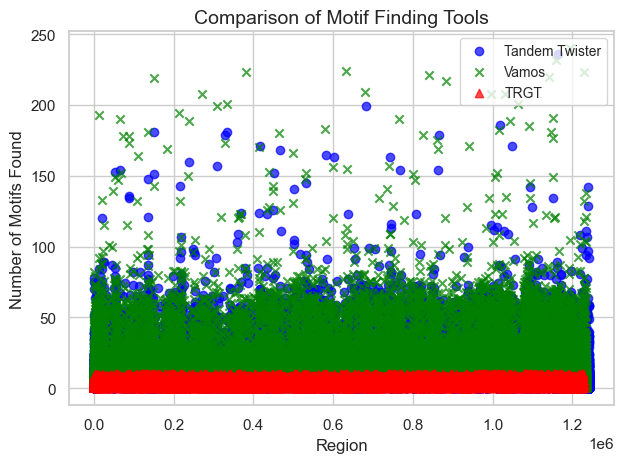

In [54]:
import matplotlib.pyplot as plt

# Create the figure and axis
fig, ax = plt.subplots()

# Plot the data with different markers and transparency for better distinction
ax.scatter(child_df_tandem_twister['index'], child_df_tandem_twister['number_of_motifs_found'], 
           label='Tandem Twister', marker='o', color='blue', alpha=0.7)
ax.scatter(child_df_vamos['index'], child_df_vamos['number_of_motifs_found'], 
           label='Vamos', marker='x', color='green', alpha=0.7)
ax.scatter(child_df_tandem_TRGT['index'], child_df_tandem_TRGT['number_of_motifs_found'], 
           label='TRGT', marker='^', color='red', alpha=0.7)

# Set labels and title
ax.set_xlabel('Region', fontsize=12)
ax.set_ylabel('Number of Motifs Found', fontsize=12)
ax.set_title('Comparison of Motif Finding Tools', fontsize=14)

# Add gridlines for easier reading of points
ax.grid(True)

# Add a legend in the upper right corner
ax.legend(loc='upper right', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:

tandemtwister = get_mendelian_consistency(child_df_tandem_twister, father_df_tandem_twister, mother_df_tandem_twister, 'tandem_twister', child_sex)
#print_mendalian_consistency_per_motif_size(tandemtwister)
print ("number of regions in tandemtwister ", tandemtwister.shape[0])   
print("percentage of mendelian consistent regions for tandemtwister ", tandemtwister['mendelian_consistent'].sum()/tandemtwister.shape[0])
print("percentage of mendelian consistent regions for tandemtwister with motif size > 1 ", tandemtwister[tandemtwister['max_motif_size'] > 1]['mendelian_consistent'].sum()/tandemtwister[tandemtwister['max_motif_size'] > 1].shape[0])
print("recall for tandemtwister ", tandemtwister.shape[0]/1243954)
# save the regions where the mendelian consistency is not met
#
# number of regions in tandemtwister  1243404
# percentage of mendelian consistent regions for tandemtwister  0.9304288871517222
# percentage of mendelian consistent regions for tandemtwister with motif size > 1  0.9691139288364202
# recall for tandemtwister  0.9995578614643307


#### results after adding the occurences of the motifs to the clustering and the occurences of the nucleotides
#number of regions in tandemtwister  1243404
# percentage of mendelian consistent regions for tandemtwister  0.9069176229125852
# percentage of mendelian consistent regions for tandemtwister with motif size > 1  0.9484312159435153
# recall for tandemtwister  0.9995578614643307


###### results after adding only the occurences of the motifs to the clustering 
# number of regions in tandemtwister  1243404
# percentage of mendelian consistent regions for tandemtwister  0.9237279275279796
# percentage of mendelian consistent regions for tandemtwister with motif size > 1  0.9607385737983053


# number of regions in tandemtwister  1242676
# percentage of mendelian consistent regions for tandemtwister  0.9049720120127853
# percentage of mendelian consistent regions for tandemtwister with motif size > 1  0.9376645167758637
# recall for tandemtwister  0.9989726308207538


####### result of tandemTwister based on the mendelian consistency of each motif occurences
# number of regions in tandemtwister  1242676
# percentage of mendelian consistent regions for tandemtwister  0.9115602136035459
# percentage of mendelian consistent regions for tandemtwister with motif size > 1  0.9430794419174794
# recall for tandemtwister  0.9989726308207538
####### result of tandemTwister based on the mendelian consistency of copy number in the region 
# number of regions in tandemtwister  1242676
# percentage of mendelian consistent regions for tandemtwister  0.9439258503423258
# percentage of mendelian consistent regions for tandemtwister with motif size > 1  0.9743753446398862
# recall for tandemtwister  0.9989726308207538

In [ ]:
TRGT = get_mendelian_consistency(child_df_tandem_TRGT, father_df_tandem_TRGT, mother_df_tandem_TRGT, 'TRGT',child_sex)
#print_mendalian_consistency_per_motif_size(TRGT)
print ("number of  regions in TRGT ", TRGT.shape[0])
print("Number of mendelian consistent regions for TRGT ", TRGT['mendelian_consistent'].sum()/TRGT.shape[0])
print("Number of mendelian consistent regions for TRGT with motif size > 1 ", TRGT[TRGT['max_motif_size'] > 1]['mendelian_consistent'].sum()/TRGT[TRGT['max_motif_size'] > 1].shape[0])
# print("recall for TRGT ", TRGT.shape[0]/1243954)
# number of  regions in TRGT  1228157
# Number of mendelian consistent regions for TRGT  0.9493102266241206
# Number of mendelian consistent regions for TRGT with motif size > 1  0.9720300427257765
# recall for TRGT  0.9873009773673304
###### results of TRGT based on the mendelian consistency of each motif occurences
# number of  regions in TRGT  1237813
# Number of mendelian consistent regions for TRGT  0.9282573377400302
# Number of mendelian consistent regions for TRGT with motif size > 1  0.9448034752455079
###### results of TRGT based on the mendelian consistency of copy number in the region
# number of  regions in TRGT  1237813
# Number of mendelian consistent regions for TRGT  0.9535301374278667
# Number of mendelian consistent regions for TRGT with motif size > 1  0.9744368595832169


In [ ]:
vamos = get_mendelian_consistency(child_df_vamos, father_df_vamos, mother_df_vamos, 'vamos',child_sex)
#print_mendalian_consistency_per_motif_size(vamos)
print ("number of regions in vamos ", vamos.shape[0])
print("Number of mendelian consistent regions for vamos ", vamos['mendelian_consistent'].sum()/vamos.shape[0])
print("Number of mendelian consistent regions for vamos with motif size > 1 ", vamos[vamos['max_motif_size'] > 1]['mendelian_consistent'].sum()/vamos[vamos['max_motif_size'] > 1].shape[0])
print("recall for vamos ", vamos.shape[0]/1243954)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3

def mendelian_consistency_rate(df, tool_name):
    consistency_rate = df['mendelian_consistent'].mean() * 100
    print(f'{tool_name} Mendelian Consistency Rate: {consistency_rate:.2f}%')
    return consistency_rate


def plot_mendelian_consistency_rate(tandemtwister, TRGT, vamos):
    rates = [
        mendelian_consistency_rate(tandemtwister, 'TandemTwister'),
        mendelian_consistency_rate(TRGT, 'TRGT'),
        mendelian_consistency_rate(vamos, 'VAMOS')
    ]
    tools = ['TandemTwister', 'TRGT', 'VAMOS']
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=tools, y=rates)
    plt.ylabel('Mendelian Consistency Rate (%)')
    plt.title('Mendelian Consistency Rate by Tool')
    plt.show()

def plot_venn_diagram(tandemtwister, TRGT, vamos):

    plt.figure(figsize=(8, 6))
    regions_tandemtwister = set(tandemtwister[tandemtwister['mendelian_consistent']]['region'])
    regions_TRGT = set(TRGT[TRGT['mendelian_consistent']]['region'])
    regions_vamos = set(vamos[vamos['mendelian_consistent']]['region'])
    plt.figure(figsize=(8, 8))
    venn3(
        [regions_tandemtwister, regions_TRGT, regions_vamos],
        ('TandemTwister', 'TRGT', 'VAMOS')
    )

    plt.title('Number of Regions Called by Each Tool')
    plt.show()
def calcluate_error_rate_by_region(row):
    # calculate the error rate by assiging the hap1_child to either hap1_father or hap2_father and hap2_child to either hap1_mother or hap2_mother based on the minimum error rate
    if (row["chrom"] != "X" and row["chrom"] != "Y"):
        error_rate_h1_father_h1_mother = abs(row['CN_H1_child'] - row['CN_H1_father']) + abs(row['CN_H1_child'] - row['CN_H1_mother'])
        error_rate_h1_father_h2_mother = abs(row['CN_H1_child'] - row['CN_H1_father']) + abs(row['CN_H1_child'] - row['CN_H2_mother'])
        error_rate_h2_father_h1_mother = abs(row['CN_H2_child'] - row['CN_H2_father']) + abs(row['CN_H2_child'] - row['CN_H1_mother'])
        error_rate_h2_father_h2_mother = abs(row['CN_H2_child'] - row['CN_H2_father']) + abs(row['CN_H2_child'] - row['CN_H2_mother'])

        error_rate = min(
            error_rate_h1_father_h1_mother,
            error_rate_h1_father_h2_mother,
            error_rate_h2_father_h1_mother,
            error_rate_h2_father_h2_mother
        )

        return error_rate
    else:
        if row["chrom"] == "X":
            error_rate_h1_father_h1_mother = abs(row['CN_H1_child'] - row['CN_H1_father']) + abs(row['CN_H1_child'] - row['CN_H1_mother'])
            error_rate_h1_father_h2_mother = abs(row['CN_H1_child'] - row['CN_H1_father']) + abs(row['CN_H1_child'] - row['CN_H2_mother'])
            error_rate = min(
                error_rate_h1_father_h1_mother,
                error_rate_h1_father_h2_mother
            )
            return error_rate
        else:
            error_rate_h1_father_h1_mother = abs(row['CN_H1_child'] - row['CN_H1_father']) + abs(row['CN_H1_child'] - row['CN_H1_mother'])
            error_rate = error_rate_h1_father_h1_mother
            return error_rate
        
def calculate_error_rate(df):
    df['error_rate'] = df.apply(calcluate_error_rate_by_region, axis=1)
    return df

def plot_error_rate(tandemtwister, TRGT, vamos):
    plt.figure(figsize=(8, 6))
    sns.histplot(tandemtwister['error_rate'], bins=100, color='blue', label='TandemTwister', kde=True)
    sns.histplot(TRGT['error_rate'], bins=100, color='red', label='TRGT', kde=True)
    #sns.histplot(vamos['error_rate'], bins=100, color='green', label='VAMOS', kde=True)
    plt.xlabel('Error Rate')
    plt.ylabel('Number of Regions')
    plt.title('Error Rate Distribution by Tool')
    plt.legend()
    plt.show()

tandemtwister = calculate_error_rate(tandemtwister)
TRGT = calculate_error_rate(TRGT)
# vamos = calculate_error_rate(vamos)




plot_mendelian_consistency_rate(tandemtwister, TRGT, vamos)
plot_venn_diagram(tandemtwister, TRGT, vamos)
plot_error_rate(tandemtwister, TRGT, vamos)

In [ ]:
TRGT 

In [ ]:
tandemtwister_nan = tandemtwister[tandemtwister.isna().any(axis=1)]
tandemtwister_nan.loc[tandemtwister["error_rate"] == tandemtwister["error_rate"].max()]
#N_H1=4821;CN_H2=4839

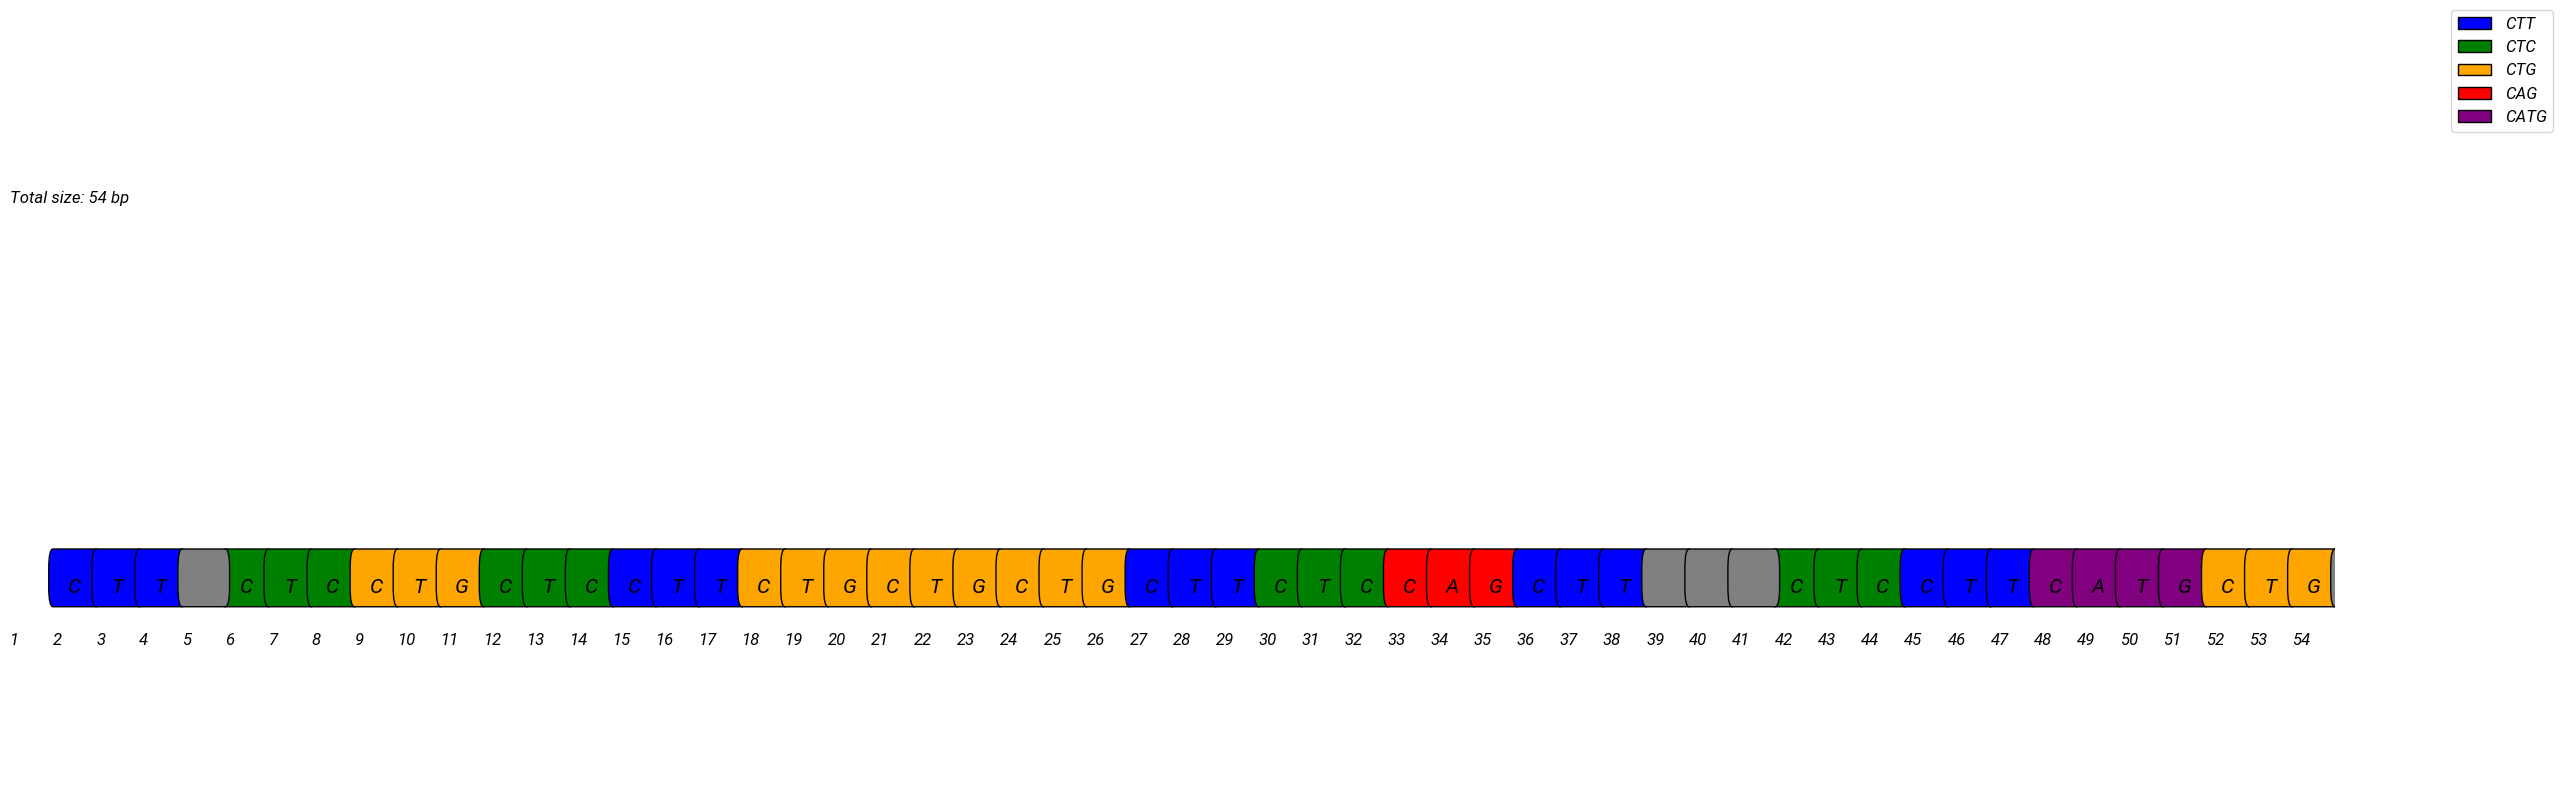

In [15]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from matplotlib.font_manager import FontProperties

prop = FontProperties(fname='/usr/share/fonts/truetype/Roboto-Italic.ttf', size=12)
data = [
    (1, 3, 'CTT'),
    (5, 7, 'CTC'),
    (8, 10, 'CTG'),
    (11, 13, 'CTC'),
    (14, 16, 'CTT'),
    (17, 19, 'CTG'),
    (20, 22, 'CTG'),
    (23, 25, 'CTG'),
    (26, 28, 'CTT'),
    (29, 31, 'CTC'),
    (32, 34, 'CAG'),
    (35, 37, 'CTT'),
    (41, 43, 'CTC'),
    (44, 46, 'CTT'),
    (47, 50, 'CATG'),
    (51, 53, 'CTG'),
]
colors = {
    'CTT': 'blue',
    'CTC': 'green',
    'CTG': 'orange',
    'CAG': 'red',
    'CATG': 'purple'
}

fig, ax = plt.subplots(figsize=(30, 10))  # Increase height of the figure

# Adjust width and height scaling factors
width_scale = 1  # One box per base pair
height_scale = 0.1  # Height of each box

# Track covered positions
covered_positions = set()

# Create base pair positions with colors based on motifs
for (start, end, motif) in data:
    for position in range(start, end + 1):
        rect = FancyBboxPatch((position * width_scale, 0.5), width_scale, 0.5 * height_scale, 
                              boxstyle="round,pad=0.1", 
                              edgecolor='black', 
                              facecolor=colors[motif],
                              mutation_aspect=0.5)
        ax.add_patch(rect)
        covered_positions.add(position)
        ax.text(position * width_scale + 0.5, 0.50, motif[position - start], ha='center', va='center', color="black", fontsize=15, fontproperties=prop)

# Add gray boxes for base pairs not covered by any motifs
for i in range(1, 55):
    if i not in covered_positions:
        rect = FancyBboxPatch((i * width_scale, 0.5), width_scale, 0.5 * height_scale, 
                              boxstyle="round,pad=0.1", 
                              edgecolor='black', 
                              facecolor='gray',
                              mutation_aspect=0.5)
        ax.add_patch(rect)

# Set the limits of the plot
ax.set_xlim(0, 54 * width_scale)
ax.set_ylim(0, 2)

# Remove axes and ticks
ax.axis('off')

# Add an annotation on the plot that shows the total size of the region 
ax.annotate('Total size: 54 bp', xy=(0, 1.5), xytext=(0, 1.5), fontsize=12, fontproperties=prop)

# Add an annotation that shows the position of each base pair underneath the boxes
for i in range(0, 54):
    ax.annotate(str(i+1), xy=(i * width_scale, 0.45), xytext=(i * width_scale, 0.35), fontsize=12, fontproperties=prop)

# Add a more stylish legend
handles = [FancyBboxPatch((0, 0), 1, 1, boxstyle="round,pad=0.1", edgecolor='black', facecolor=colors[motif]) for motif in colors]
labels = list(colors.keys())
ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop=prop)

# Display the plot
plt.show()
#CTT,CTC,CTG,CAG,CATG;SVTYPE=VNTR;ALTANNO_H1=0,1,2,1,0,2,0,0,0,1,3,0,2,1,0,4,2 Vamos
# CATG,CTT,CTC,CTG,CAG    1,2,3,2,1,3,3,3,1,2,4,1,2,1,0,3 TandemTwister
#                         1,2,3,2,1,3,1,1,1,2,4,1,2,1,0,3
                        # 1,2,3,2,1,3,1,1,1,2,4,1,0,0,3
                        # 1,2,3,2,1,3,1,1,1,2,4,1,0,0,3